<a href="https://colab.research.google.com/github/Himansh-tech/cv/blob/main/Final_deep_defect_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segmentation-models-pytorch
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0f510f04c0a82713f21c00d021a63ce7fc09f0c17f161655cdf3e44501556fcf
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=089ae8f6275f3e86c11e323a70e05dbc86fea9fc377bc4c21966e8de2bec2c73
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
# Dataset class
class CornealDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binarize mask

        return image, mask


        # This dataset class is designed to prepare images and their segmentation masks for a deep learning
        # model. By converting the mask to a binary format, it ensures that the model learns to distinguish between the defect (corneal defect area) and the background.

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [5]:
# Load Dataset
img_dir = r'/content/Resized_Corneal'  # Path to eye images (JPG)
mask_dir =r'/content/mask'  # Path to corresponding masks (PNG)
# Load Dataset
dataset = CornealDataset(img_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [6]:
# Function to calculate defect area
def calculate_defect_area(pred_mask):
    # Calculate defect area as the percentage of pixels that are part of the defect
    defect_area = np.sum(pred_mask)  # Number of pixels in defect
    total_area = pred_mask.size  # Total number of pixels
    area_percentage = (defect_area / total_area) * 100
    return area_percentage

In [7]:
# Helper function for training a model
def train_model(model, dataloader, num_epochs=20, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")


In [8]:
def evaluate_and_visualize_output(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    iou_list, dice_list, precision_list, recall_list, f1_list, defect_area_list = [], [], [], [], [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Binarize predictions

            preds_np = preds.cpu().numpy().astype(int)
            masks_np = masks.cpu().numpy().astype(int)

            # Calculate metrics
            iou = jaccard_score(masks_np.flatten(), preds_np.flatten(), zero_division=1)
            dice = f1_score(masks_np.flatten(), preds_np.flatten(), zero_division=1)
            precision = precision_score(masks_np.flatten(), preds_np.flatten(), zero_division=1)
            recall = recall_score(masks_np.flatten(), preds_np.flatten(), zero_division=1)
            f1 = f1_score(masks_np.flatten(), preds_np.flatten(), zero_division=1)

            iou_list.append(iou)
            dice_list.append(dice)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

            # Visualize each image in the batch
            for i in range(images.size(0)):
                image_np = images[i].cpu().numpy().transpose(1, 2, 0)
                mask_np = masks_np[i].squeeze()  # Original mask
                pred_np = preds_np[i].squeeze()  # Predicted mask

                # Calculate defect area for each predicted mask
                area_percentage = calculate_defect_area(pred_np)
                defect_area_list.append(area_percentage)

                # Plot and display
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(image_np)
                axes[0].set_title("Input Image")
                axes[1].imshow(mask_np, cmap="gray")
                axes[1].set_title("Ground Truth Mask")
                axes[2].imshow(pred_np, cmap="gray")
                axes[2].set_title(f"Predicted Mask\nDefect Area: {area_percentage:.2f}%")
                plt.show()
        # Helper function to evaluate and display predicted output images

    # Calculate average metrics
        avg_iou = sum(iou_list) / len(iou_list)
        avg_dice = sum(dice_list) / len(dice_list)
        avg_precision = sum(precision_list) / len(precision_list)
        avg_recall = sum(recall_list) / len(recall_list)
        avg_f1 = sum(f1_list) / len(f1_list)
        avg_defect_area = sum(defect_area_list) / len(defect_area_list)

        print(f"Average IoU: {avg_iou:.4f}")
        print(f"Average Dice: {avg_dice:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average Defect Area: {avg_defect_area:.2f}%")

In [9]:

# Define models
models = {
    "U-Net": smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1),
    "FPN": smp.FPN(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1),
}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    train_model(model, dataloader)
    print(f"Evaluating {model_name} model...")
    evaluate_and_visualize_output(model, dataloader)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 226MB/s]



Training U-Net model...
Epoch [1/20], Loss: 0.6495
Epoch [2/20], Loss: 0.4029
Epoch [3/20], Loss: 0.3221
Epoch [4/20], Loss: 0.2473
Epoch [5/20], Loss: 0.2105
Epoch [6/20], Loss: 0.1854
Epoch [7/20], Loss: 0.1654
Epoch [8/20], Loss: 0.1408


KeyboardInterrupt: 

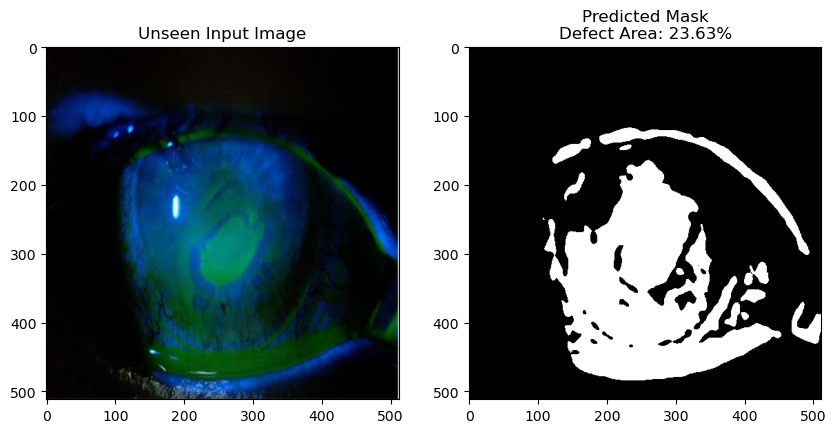

In [ ]:
def predict_on_unseen_image(model, model_name, image_path, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load and process the unseen image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        pred = torch.sigmoid(output) > 0.5  # Binarize prediction
        pred_np = pred.cpu().numpy().squeeze()  # Convert to numpy and remove batch dimension

    # Calculate defect area
    defect_area_percentage = calculate_defect_area(pred_np)

    # Display the input image and the predicted mask
    image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy array
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Unseen Input Image")
    axes[1].imshow(pred_np, cmap="gray")
    axes[1].set_title(f"Predicted Mask\nDefect Area: {defect_area_percentage:.2f}%")
    plt.show()

    print(f"{model_name} Model Prediction on Unseen Image:")
    print(f"Defect Area Percentage: {defect_area_percentage:.2f}%")

# Example usage with unseen image
unseen_image_path = "C:/Users/Admin/Desktop/CORNEAL DATASET/test/Figure1-e1650555714806.jpg"  # Replace with the actual path to your unseen image

for model_name, model in models.items():
    predict_on_unseen_image(model, model_name, unseen_image_path, transform)


In [ ]:
def predict_on_unseen_image(model, model_name, image_path, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load and process the unseen image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        pred = torch.sigmoid(output) > 0.5  # Binarize prediction
        pred_np = pred.cpu().numpy().squeeze()  # Convert to numpy and remove batch dimension

    # Calculate defect area for predicted mask
    predicted_defect_area_percentage = calculate_defect_area(pred_np)

    # Display the input image and the predicted mask
    image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy array
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Unseen Input Image")
    axes[1].imshow(pred_np, cmap="gray")
    axes[1].set_title(f"Predicted Mask\nDefect Area: {predicted_defect_area_percentage:.2f}%")
    plt.show()

    # Print out results
    print(f"{model_name} Model Prediction on Unseen Image:")
    print(f"Predicted Defect Area Percentage: {predicted_defect_area_percentage:.2f}%")

# Example usage with unseen image
unseen_image_path = "C:/Users/Admin/Desktop/CORNEAL DATASET/test/Figure1-e1650555714806.jpg"  # Replace with actual path

for model_name, model in models.items():
    predict_on_unseen_image(model, model_name, unseen_image_path, transform)
